# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/Tako/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Tako/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
### STUDENT START ###

    for i in range(0, num_examples):
        print "Label: {}\nData: {}".format(train_labels[i], train_data[i])
### STUDENT END ###
P1()

Label: 1
Data: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
Label: 3
Data: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
Label: 2
Data: 
 >In article <1

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [4]:
def P2():
### STUDENT START ###

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    
    # a
    print X.shape
    print X.nnz
    print len(vectorizer.get_feature_names())
    print "Size of the vacabulary: {}".format(X.shape[1])
    print "Average number of non-zero features per example: {0:.3g}".format((float(X.nnz)/X.shape[1]))
    print "Fraction of the non-zero entries in the matrix: {0:.3g}".format((float(X.nnz)/(X.shape[0]*X.shape[1])))
    
    # b
    print "0th feature string in alphabetical order: {}".format(vectorizer.get_feature_names()[0])
    print "Last feature string in alphabetical order: {}".format(vectorizer.get_feature_names()[X.shape[1]-1])
    
    # c
    vocab = ["atheism", "graphics", "space", "religion"]
    X_2 = vectorizer.fit_transform(vocab)
    print X_2.shape
    print X_2.nnz
    print "Average number of non-zero features per example: {0:.3g}".format((float(X_2.nnz)/X_2.shape[1]))
    
    # d
    
    ## Bigram
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'\b\w+\b', min_df=1)
    analyze = bigram_vectorizer.build_analyzer()
    X_bi = bigram_vectorizer.fit_transform(train_data)
    print "Size of the bigram vacabulary: {}".format(X_bi.shape[1])
    
    ## Trigram
    triram_vectorizer = CountVectorizer(ngram_range=(3, 3), token_pattern=r'\b\w+\b', min_df=1)
    analyze = triram_vectorizer.build_analyzer()
    X_tri = triram_vectorizer.fit_transform(train_data)
    print "Size of the trigram vacabulary: {}".format(X_tri.shape[1])

    # e
    min_10_vectorizer = CountVectorizer(min_df=10)
    X_min_10 = min_10_vectorizer.fit_transform(train_data)
    print "Size of the vacabulary with min_df = 10: {}".format(X_min_10.shape[1])

    # f
    dev_vectorizer = CountVectorizer()
    X_dev = dev_vectorizer.fit_transform(dev_data)
    print "Size of the dev_data vacabulary: {}".format(X_dev.shape[1])
    print "Number of the words in the dev data missing from the vacabulary: {}".format(X.shape[1] - X_dev.shape[1])
    print "Fraction of the words in the dev data missing from the vacabulary: {0:.3g}".format((float(X.shape[1]) - X_dev.shape[1])/X.shape[1])

### STUDENT END ###
P2()

(2034, 26879)
196700
26879
Size of the vacabulary: 26879
Average number of non-zero features per example: 7.32
Fraction of the non-zero entries in the matrix: 0.0036
0th feature string in alphabetical order: 00
Last feature string in alphabetical order: zyxel
(4, 4)
4
Average number of non-zero features per example: 1
Size of the bigram vacabulary: 196586
Size of the trigram vacabulary: 329269
Size of the vacabulary with min_df = 10: 3064
Size of the dev_data vacabulary: 16246
Number of the words in the dev data missing from the vacabulary: 10633
Fraction of the words in the dev data missing from the vacabulary: 0.396


Answer:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

Size of the vacabulary: 26879
Average number of non-zero features per example: 7.32
Fraction of the non-zero entries in the matrix: 0.0036

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

0th feature string in alphabetical order: 00
Last feature string in alphabetical order: zyxel

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

Average number of non-zero features per example: 1

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

Size of the bigram vacabulary: 196586
Size of the trigram vacabulary: 329269

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

Size of the vacabulary with min_df = 10: 3064

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

Size of the dev_data vacabulary: 16246
Number of the words in the dev data missing from the vacabulary: 10633
Fraction of the words in the dev data missing from the vacabulary: 0.396

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [5]:
def P3():
### STUDENT START ###

    # Instantiate CountVectorizer
    vectorizer = CountVectorizer()
    
    # Transform data
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)
    
    # Instantiate KNN
    clf_knn = KNeighborsClassifier()

    # Find the optimal value for k using GridSearchCV
    k_vals = { 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50, 75, 95, 100, 1000]}
    param_searcher = GridSearchCV(clf_knn, k_vals)
    param_searcher.fit(X_train, train_labels)
    print "Best K Value: {} Best Score: {:.4}".format(
        param_searcher.best_params_['n_neighbors'],
        param_searcher.best_score_
    )

    clf_knn.set_params(n_neighbors = param_searcher.best_params_['n_neighbors'])
    clf_knn.fit(X_train, train_labels)
    preds = clf_knn.predict(X_dev)
    print 'F1 Score - k nearest neighbors classifier (k={0}): {1:.3g}'.format(
        param_searcher.best_params_['n_neighbors'],
        metrics.f1_score(dev_labels, preds, average='macro')
    )
    
    # Instantiate MultinomialNB
    clf_mnb = MultinomialNB()

    # Find the optimal value for alpha using GridSearchCV
    alpha_vals = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    param_searcher = GridSearchCV(clf_mnb, alpha_vals)
    param_searcher.fit(X_train, train_labels)
    print "Best Alpha Value: {} Best Score: {:.4}".format(
        param_searcher.best_params_['alpha'],
        param_searcher.best_score_
    )
   
    clf_mnb.set_params(alpha=param_searcher.best_params_['alpha'])
    clf_mnb.fit(X_train, train_labels)
    preds = clf_mnb.predict(X_dev)
    print 'F1 Score - MultinomialNB classifier (alpha={0}): {1:.3g}'.format(
        param_searcher.best_params_['alpha'],
        metrics.f1_score(dev_labels, preds, average='macro')
    )

    # Instantiate LogisticRegression with L2 regularization
    clf_lr = LogisticRegression()
    
    # Find the optimal value for C using GridSearchCV
    c_vals = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100, 1000, 1e18]}
    param_searcher = GridSearchCV(clf_lr, c_vals)
    param_searcher.fit(X_train, train_labels)
    print "Best C Value: {} Best Score: {:.4}".format(
        param_searcher.best_params_['C'],
        param_searcher.best_score_
    )
   
    clf_lr.fit(X_train, train_labels)
    preds = clf_lr.predict(X_dev)
    print 'F1 Score - LogisticRegression classifier (C={0}): {1:.3g}'.format(
        param_searcher.best_params_['C'],
        metrics.f1_score(dev_labels, preds, average='macro')
    )
    
### STUDENT END ###
P3()

Best K Value: 95 Best Score: 0.4425
F1 Score - k nearest neighbors classifier (k=95): 0.438


/Users/Tako/anaconda2/lib/python2.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best Alpha Value: 0.01 Best Score: 0.8284
F1 Score - MultinomialNB classifier (alpha=0.01): 0.755
Best C Value: 0.5 Best Score: 0.7714
F1 Score - LogisticRegression classifier (C=0.5): 0.679


In [6]:
def P3_C():
### STUDENT START ###

    # Internal function for computing summed weight
    def calc_sum_weight(coef):
        for i in range(0, len(coef)):
            print "Weight Sum for Class {}: {}".format(i, np.sum(coef[i] ** 2))

    # Instantiate CountVectorizer
    vectorizer = CountVectorizer()
    
    # Transform data
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)
    
    # Instantiate LogisticRegression with L2 regularization
    clf_lr = LogisticRegression()
    
    # C valuess
    c_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100, 1000, 1e18]

    for c in c_vals:
        clf_lr.set_params(C=c)
        clf_lr.fit(X_train, train_labels)
        preds = clf_lr.predict(X_dev)
        print 'F1 Score - LogisticRegression classifier (C={0}): {1:.3g}'.format(
            c,
            metrics.f1_score(dev_labels, preds, average='macro')
        )
        calc_sum_weight(clf_lr.coef_)

### STUDENT END ###
P3_C()

F1 Score - LogisticRegression classifier (C=0.0001): 0.518
Weight Sum for Class 0: 0.00770174944675
Weight Sum for Class 1: 0.0119412003106
Weight Sum for Class 2: 0.00943507686564
Weight Sum for Class 3: 0.00910283529383
F1 Score - LogisticRegression classifier (C=0.001): 0.597
Weight Sum for Class 0: 0.165093451668
Weight Sum for Class 1: 0.200952746906
Weight Sum for Class 2: 0.180670937543
Weight Sum for Class 3: 0.187242784378
F1 Score - LogisticRegression classifier (C=0.01): 0.645
Weight Sum for Class 0: 2.54148768255
Weight Sum for Class 1: 2.93970936836
Weight Sum for Class 2: 2.86246910169
Weight Sum for Class 3: 2.25002918952
F1 Score - LogisticRegression classifier (C=0.1): 0.679
Weight Sum for Class 0: 27.1362351115
Weight Sum for Class 1: 24.6595673235
Weight Sum for Class 2: 27.4587234794
Weight Sum for Class 3: 23.0260045509
F1 Score - LogisticRegression classifier (C=0.5): 0.692
Weight Sum for Class 0: 102.513457187
Weight Sum for Class 1: 83.1021581712
Weight Sum for 

ANSWER:

a. Why doesn't nearest neighbors work well for this problem?

Nearest neighbors doens't work well for this problem due to the high number of features (dimensions) evident in the dataset we are working with.

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

Logistic regression does not work as well as Naive Bayes in this case because logistic regression works the best for classifying boolean data whereas Multinominal Naive Bayes is designed to handle multi-class discrete data.

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

As can be seen by the output of P3_C(), the sum of the squard weight vlues for each class increases as the value of C increases.


(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [7]:
def P4():
### STUDENT START ###

    def get_nth_largest_index(arr, n):
        if n > len(arr):
            return False
        
        if n < 1:
            return False
        
        if n == 1:
            return arr.index(max(arr))
        
        arr[arr.index(max(arr))] = None
        
        return get_nth_largest_index(arr, n-1)


    # Instantiate CountVectorizer
    vectorizer = CountVectorizer()
    
    # Transform data
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)
    
    # Instantiate LogisticRegression with L2 regularization
    clf_lr = LogisticRegression()
    
    # Initialize C with the optimal value computed earlier
    c = 0.5
    
    clf_lr.set_params(C=c)
    clf_lr.fit(X_train, train_labels)
    preds = clf_lr.predict(X_dev)
    coef = clf_lr.coef_.tolist()

    indice = []
    
    # Get indice for largest weights
    for i in range(0, len(coef)):
        for j in range(1, 5):
            indice.append(get_nth_largest_index(coef[i], j))

    # Get a fresh list of coefficients
    coef = clf_lr.coef_.tolist()
    
    arr = []
    
    # Collect weights
    for i in range(0, len(indice)):
        arr.append([])
        for j in range(0, len(coef)):
            arr[i].append(coef[j][indice[i]])
       
    df = pd.DataFrame(arr, columns=categories)
    
    # Print the data
    print df

    # Now we'll repeat this for bigram
    
    ## Instantiate bigram vectorizer
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'\b\w+\b', min_df=1)
    X_bi = bigram_vectorizer.fit_transform(train_data)
    X_bi_dev = bigram_vectorizer.transform(dev_data)

    # Instantiate LogisticRegression with L2 regularization
    clf_lr = LogisticRegression()
    clf_lr.fit(X_bi, train_labels)
    preds = clf_lr.predict(X_bi_dev)
    coef_bi = clf_lr.coef_.tolist()

    indice = []
    
    # Get indice for largest weights
    for i in range(0, len(coef_bi)):
        for j in range(1, 5):
            indice.append(get_nth_largest_index(coef_bi[i], j))

    # Get a fresh list of coefficients
    coef_bi = clf_lr.coef_.tolist()
    
    arr_bi = []
    
    # Collect weights
    for i in range(0, len(indice)):
        arr_bi.append([])
        for j in range(0, len(coef_bi)):
            arr_bi[i].append(coef_bi[j][indice[i]])
       
    df_bi = pd.DataFrame(arr_bi, columns=categories)
    
    # Print the data
    print "\nBigram: \n{}".format(df_bi)
    
### STUDENT END ###
P4()

    alt.atheism  talk.religion.misc  comp.graphics  sci.space
0      0.832119           -0.093456      -0.267107  -0.637606
1      0.823690           -0.191303      -0.286562  -0.387156
2      0.793995           -0.350952      -0.367167  -0.377007
3      0.673885           -0.103367      -0.285265  -0.290031
4     -0.641205            1.625936      -1.103125  -0.626308
5     -0.468683            1.117015      -0.671884  -0.381255
6     -0.303641            0.941824      -0.571095  -0.317591
7     -0.502428            0.731851      -0.258723  -0.525994
8     -1.061110           -1.116107       1.863778  -0.972125
9     -0.350376           -0.559592       1.012597  -0.498962
10    -0.376461           -0.396786       0.783752  -0.280916
11    -0.529417           -0.520932       0.648405   0.126582
12    -0.607123           -0.315351      -0.404374   0.929423
13    -0.483107           -0.339053      -0.247399   0.925525
14    -0.244036           -0.217507      -0.374844   0.754721
15    -0

ANSWER: Although the weight values are different between the 2 models, they follow the same pattern in that for a given nth row, we see the largest value for the same label.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [8]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    s = re.sub(r'[^a-zA-Z0-9\s_\-]', '#', s)  # Replace non-word characters with an arbitrary token
    s = re.sub(r'[#]{2,}', '#', s)  # Eliminate redundant tokens
    s = re.sub(r'\t', '', s) # Eliminate tabs
    s = re.sub(r'\r\n|\n\r|\r', '', s) # Eliminate carriage returns
    s = re.sub(r'\n\n', '', s) # Eliminate redundant linebreaks
    s = re.sub(r'\s{2,}', ' ', s) # Eliminate redundant spaces
    return s
### STUDENT END ###

def P5():
### STUDENT START ###

    # Internal function for running Logistic Regression
    def run_lr(train_data, train_labels, dev_data, dev_labels, preprocessor):
        vectorizer = CountVectorizer(preprocessor=preprocessor)
        X_train = vectorizer.fit_transform(train_data)
        X_dev = vectorizer.transform(dev_data)

        # Instantiate LogisticRegression
        clf = LogisticRegression()
        clf.fit(X_train, train_labels)
        preds = clf.predict(X_dev)
        f1 = metrics.f1_score(dev_labels, preds, average='macro')
        print 'F1 Score - Logistic Regression classifier: {0:.3g}'.format(
            f1
        )
        return f1

    # Run Logistic Regression with no preprocessor
    score_1 = run_lr(train_data, train_labels, dev_data, dev_labels, None)
    
    # Run Logistic Regression with empty preprocessor
    score_2 = run_lr(train_data, train_labels, dev_data, dev_labels, empty_preprocessor)
    
    # Run Logistic Regression with better preprocessor
    score_3 = run_lr(train_data, train_labels, dev_data, dev_labels, better_preprocessor)
    
    print "Using better_preprocessor, the F1 score has improved by {0:.3g}".format(score_3 - score_2)
        
### STUDENT END ###
P5()

F1 Score - Logistic Regression classifier: 0.679
F1 Score - Logistic Regression classifier: 0.687
F1 Score - Logistic Regression classifier: 0.69
Using better_preprocessor, the F1 score has improved by 0.00342


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Number of non-zero weights using L1 penalty with C = 0.0001: 0
F1 Score - Logistic Regression classifier using L1 penalty: 0.0981
Non-zero weights not found for the C value 0.0001
Number of non-zero weights using L1 penalty with C = 0.001: 5
F1 Score - Logistic Regression classifier using L1 penalty: 0.241
F1 Score - Logistic Regression classifier using L2 penalty: with C = 0.001 and 5 features: 0.284
Number of non-zero weights using L1 penalty with C = 0.01: 35
F1 Score - Logistic Regression classifier using L1 penalty: 0.412
F1 Score - Logistic Regression classifier using L2 penalty: with C = 0.01 and 35 features: 0.442
Number of non-zero weights using L1 penalty with C = 0.1: 358
F1 Score - Logistic Regression classifier using L1 penalty: 0.613
F1 Score - Logistic Regression classifier using L2 penalty: with C = 0.1 and 358 features: 0.664
Number of non-zero weights using L1 penalty with C = 0.5: 1170
F1 Score - Logistic Regression classifier using L1 penalty: 0.673
F1 Score - Logis

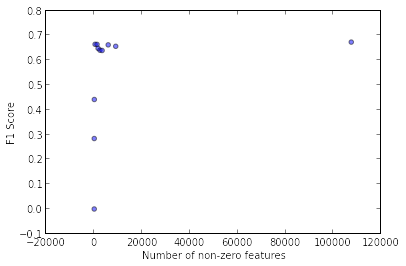

In [24]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    
    # Internal function for running Logistic Regression
    def run_lr(c, X_train, train_labels, X_dev, dev_labels):
        # Create our 1st LogisticRegression object with L1 penalty
        clf_l1 = LogisticRegression(penalty='l1', C=c)
        clf_l1.fit(X_train, train_labels)
        weights = clf_l1.coef_
        print "Number of non-zero weights using L1 penalty with C = {0}: {1}".format(c, len(weights[weights != 0]))
        preds = clf_l1.predict(X_dev)
        print 'F1 Score - Logistic Regression classifier using L1 penalty: {0:.3g}'.format(
            metrics.f1_score(dev_labels, preds, average='macro')
        )

        non_zero = []

        for i in range(0, len(weights)):
            for j in range(0, len(weights[i])):
                if weights[i][j] != 0:
                    non_zero.append(j)
        
        if len(non_zero) == 0:
            print "Non-zero weights not found for the C value {}".format(c)
            return [False, False]
        
        # Create our 2nd LogisticRegression object with L2 penalty
        clf_l2 = LogisticRegression(C=c)
        clf_l2.fit(X_train[:,non_zero], train_labels)
        preds = clf_l2.predict(X_dev[:,non_zero])
        f1 = metrics.f1_score(dev_labels, preds, average='macro')
        print 'F1 Score - Logistic Regression classifier using L2 penalty: with C = {0} and {1} features: {2:.3g}'.format(
            c,
            len(non_zero),
            f1
        )
        return [f1, len(non_zero)]
    
    # Instantiate CountVectorizer
    vectorizer = CountVectorizer(preprocessor=None)
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)
             
    # C values
    c_vals = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100, 1000, 1e18]}

    # Initialize arrays for plotting
    f1_arr = []
    non_zero_arr = []
    
    # Compute F1 scores and number of non-zero weights
    for c in c_vals['C']:
        f1, non_zero = run_lr(c, X_train, train_labels, X_dev, dev_labels)
        f1_arr.append(f1)
        non_zero_arr.append(non_zero)
       
    # Plot results
    plt.scatter(non_zero_arr, f1_arr, alpha=0.5)
    plt.xlabel('Number of non-zero features')
    plt.ylabel('F1 Score')
    plt.show()
    
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [10]:
#def P7():
### STUDENT START ###

## STUDENT END ###
#P7()

ANSWER:

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.